# Landcover classification based on spectral-temporal metrics

Author: Andreas Mayr

Date: 13 April 2023

This Notebook shows how to use spectral-temporal metrics as features for a supervised landcover classification. These metrics are derived from a Sentinel-2 satellite image time series in the Google Earth Engine (GEE) with related Python packages. The supervised machine learning part is accomplished on your local machine using the scikit-learn machine learning library. Xarrays is used for raster time series handling.

Additionally, a simple approach for unsupervised classification is tried for comparison towards the end of the Notebook.

Data:

* We will download the Sentinel-2 time series metrics from the Google Earth Engine.
* Two geopackages with an area-of-interest polygon and a reference data point layer, respectively, are provided for download on the course data repository in the theme 3 folder:
    * `/T3/aoi.gpkg`
    * `/T3/ref_data.gpkg`

## Set up the environment

Use the `m1_etrainee` environment containing the required packages, or create it now to install the packages.

```
conda create -n m1_etrainee python=3.9
conda activate m1_etrainee
conda install mamba
mamba install ipykernel earthengine-api eemont geemap wxee pygis geopandas seaborn hvplot scikit-learn datashader stackstac xarrayutils xmovie
```

Some of the packages are not needed here but in related Notebooks. Now we might have to re-start or refresh VSCode to actually be able to select the environment as a kernel.

### Area-of-interest (AOI) and a reference data set

Import some of the required packages.

In [2]:
import ee, eemont, geemap, wxee         # ee is the GEE Python API, the others are extensions to that
import folium
import geopandas as gpd
import pathlib

Set the directory where data is stored. Save the AOI and the reference data there.

In [10]:
data_dir = pathlib.Path('C:/work/etrainee/gee/T3') / 'data' # Define path on your local system
data_dir

WindowsPath('C:/work/etrainee/gee/T3/data')

We import two geopackages outlining our area-of-interest (AOI) and a reference data set, respectively, and we load them to a map. Both geopackages are available on the course data repository in the theme 3 folder (`/T3/aoi.gpkg` and `/T3/ref_data.gpkg`).

We use GeoPandas to import a Geopackage with our Area-of-Interest (AOI). The simplest way to get an interactive map with our AOI is the Geopandas `explore()` method.

In [6]:
my_aoi = gpd.read_file(data_dir / 'aoi.gpkg')
my_aoi.explore()

Read a Geopackage with reference data for landcover to a Geopandas Dataframe.

In [7]:
ref_data = gpd.read_file(data_dir / 'ref_data.gpkg')

The landcover classes are coded with label IDs and we add a new column with the landcover classes named by strings.

In [8]:
landcover_dict={
    1: "Grassland",
    2: "Cropland",
    3: "Forest",
    4: "Water",
    5: "Other"
}
ref_data["landcover_string"] = ref_data['landcover'].map(landcover_dict)    # Map values of the new column according to the dictionary 
ref_data                                                                    # Show the DataFrame

,landcover,geometry,landcover_string
0,1,POINT (682379.903 5238921.551),Grassland
1,1,POINT (682521.253 5239272.683),Grassland
2,1,POINT (682951.614 5238795.907),Grassland
3,1,POINT (682490.123 5239846.356),Grassland
4,1,POINT (683024.953 5239605.725),Grassland
...,...,...,...
67,5,POINT (684383.764 5238819.044),Other
68,5,POINT (683702.255 5238405.091),Other
69,5,POINT (683539.871 5238396.677),Other
70,5,POINT (683578.293 5238347.597),Other


For plotting we define a colormap associated to the landcover classes in alphabetical order.

In [6]:
#my_colors = {"Grassland": "green", "Cropland": "brown", "Forest": "darkgreen", "Water": "blue", "Other": "grey"}
my_colors = ("brown", "darkgreen", "lightgreen", "grey", "blue")

Create an interactive map with the two vector layers (*AOI* and *Landcover*).

In [7]:
# Show AOI
m = my_aoi.explore(                                     # Show the AOI in a Folium map object
    name="AOI",
    style_kwds={"fill": False}                          # Do not fill the polygon
)

# Add landcover point layer
ref_data.explore(
    m=m,                                                # Pass the map object
    column="landcover_string",                          # Column to use for color
    name="Landcover",                                   # Layer name in the map
    marker_kwds={"radius": 4},                          # Set marker circle size in pixels
    style_kwds={"color": "black", "weight": 1},         # Set marker stroke color and width in pixels
    cmap=my_colors,                                     # Use the custom colormap
    legend=True 
)

folium.TileLayer('CartoDB positron', control=True).add_to(m)    # Add alternative tiles as background map
folium.LayerControl(collapsed=False).add_to(m)                  # Add layer control
m                                                               # Show map

Alternatively, a simple geopandas and xarray plot overlay is shown here:
https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python-xarray/


## Sentinel-2 time series metrics

We retrieve the spectral-temporal metrics from the Google Earth Engine (GEE) using the [geemap](https://geemap.org/), [wxee](https://wxee.readthedocs.io/en/latest/index.html) and [eemont](https://eemont.readthedocs.io/) packages.

Authenticate and initialize Google Earth Engine:

In [8]:
try:
        wxee.Initialize()       # Works similarly to ee.Initialize but automatically connects to the high-volume GEE endpoint
except Exception as e:          # If initialize does not work, you probably have to authenticate first
        ee.Authenticate()
        wxee.Initialize()

From GEE, retrieve an image collection for our AOI and for the year 2019 (we have reference data for the same year), limit the search by a maximum cloudy pixel percentage per scene. We exclude the winter months where snow cover could compromise the spectral time series. The eemont preprocess method automatically masks clouds and shadows, and it scales and offsets the image or image collection. The eemont spectralIndices method can calculate any index from the [Awesome Spectral Indices](https://awesome-ee-spectral-indices.readthedocs.io/en/latest/) library but for simplicity we only take the NDVI.

In [9]:
aoi_fc = geemap.gdf_to_ee(my_aoi)            # Convert the AOI from GeoPandas GeoDataFrame to ee.FeatureCollection

S2 = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterDate("2019-04-01","2019-10-31") \
    .filterBounds(aoi_fc) \
    .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 50) \
    .preprocess() \
    .spectralIndices("NDVI")

*The newer COPERNICUS/S2_SR_HARMONIZED collection results in an error later on (when calling S2_ts.describe()).*

Create a wxee TimeSeries object to enable xarray operations, such as temporal aggregations. For convenience, we select only the NDVI, omitting all the original bands.

In [10]:
S2_ts = S2.select('NDVI').wx.to_time_series()

First, get some info about our time series.

In [11]:
S2_ts.describe()

COPERNICUS/S2_SR
	Images: 33
	Start date: 2019-04-02 10:27:44 UTC
	End date: 2019-10-26 10:17:45 UTC
	Mean interval: 6.47 days


And plot the timeline to see how the (low-cloudiness) observations are distributed over the observation period.

In [12]:
S2_ts.wx.to_time_series().timeline()

### Feature extraction

To create spectral-temporal metrics that can be used as classification features, we perform a temporal aggregation (calculate pixel-level seasonal statistics) of our time series in the GEE. We define the frequency as *year* but in fact it will be an aggregation over the growing season as our time series covers only the months April to October 2019.

In [15]:
S2_seasonal_mean_ts= S2_ts.aggregate_time(frequency="year", reducer=ee.Reducer.mean(), keep_bandnames=False)    # We do not keep band names only but append the name of the reducer to the band names.
S2_seasonal_std_ts= S2_ts.aggregate_time(frequency="year", reducer=ee.Reducer.stdDev(), keep_bandnames=False)
S2_seasonal_min_ts= S2_ts.aggregate_time(frequency="year", reducer=ee.Reducer.min(), keep_bandnames=False)
S2_seasonal_max_ts= S2_ts.aggregate_time(frequency="year", reducer=ee.Reducer.max(), keep_bandnames=False)

### Downloading features from GEE

The nice thing is that so far all the big computations on the time series data happened in the cloud (GEE). Now use wxee to download the results of the time series aggregation to xarray Datasets. Note that wxee, however, is not designed to download larger areas and high resolution - in such cases consider downloading to a Google Drive using ee or to a local drive using geemap.

Either define a path where a NetCDF file will be written to, or load the Dataset into memory only.
You can set the scale parameter to control the resolution. See the [documentation](https://wxee.readthedocs.io/en/latest/generated/wxee.collection.ImageCollection.to_xarray.html) for more options.

The requests and downloads may take some minutes.

In [16]:
s_mean_path = data_dir / "S2_seasonal_mean.nc"
s_std_path = data_dir / "S2_seasonal_std.nc"
s_min_path = data_dir / "S2_seasonal_min.nc"
s_max_path = data_dir / "S2_seasonal_max.nc"

S2_seasonal_mean_ds = S2_seasonal_mean_ts.wx.to_xarray(path=s_mean_path, region = aoi_fc.geometry(), crs='EPSG:25832', scale=10)
S2_seasonal_std_ds = S2_seasonal_std_ts.wx.to_xarray(path=s_std_path, region = aoi_fc.geometry(), crs='EPSG:25832', scale=10)
S2_seasonal_min_ds = S2_seasonal_min_ts.wx.to_xarray(path=s_min_path, region = aoi_fc.geometry(), crs='EPSG:25832', scale=10)
S2_seasonal_max_ds = S2_seasonal_max_ts.wx.to_xarray(path=s_max_path, region = aoi_fc.geometry(), crs='EPSG:25832', scale=10)

Requesting data:   0%|          | 0/1 [00:00<?, ?it/s]

Requesting data:   0%|          | 0/1 [00:00<?, ?it/s]

Requesting data:   0%|          | 0/1 [00:00<?, ?it/s]

Requesting data:   0%|          | 0/1 [00:00<?, ?it/s]

Combine all Datasets with seasonal statistics into one Dataset (using their common dimension coordinates). This new Dataset contains all the seasonal statistics (spectral-temporal metrics) but is limited to one time stamp because we aggregated all observations into seasonal metrics.

In [17]:
import xarray as xr

S2_seasonal_ds = xr.combine_by_coords([S2_seasonal_mean_ds, S2_seasonal_std_ds, S2_seasonal_min_ds, S2_seasonal_max_ds])
S2_seasonal_ds

<xarray.Dataset>
Dimensions:      (time: 1, y: 428, x: 767)
Coordinates:
  * time         (time) datetime64[ns] 2019-04-02T10:27:44
  * y            (y) float64 5.242e+06 5.242e+06 ... 5.237e+06 5.237e+06
  * x            (x) float64 6.818e+05 6.818e+05 ... 6.895e+05 6.895e+05
Data variables:
    NDVI_max     (time, y, x) float64 0.6992 0.7314 0.7144 ... 0.8441 0.9075
    NDVI_mean    (time, y, x) float64 0.5153 0.5224 0.5348 ... 0.7466 0.7546
    NDVI_min     (time, y, x) float64 0.1644 0.1643 0.1623 ... 0.2692 0.3074
    NDVI_stdDev  (time, y, x) float64 0.147 0.1533 0.1561 ... 0.1084 0.1111
Attributes:
    transform:               (10.0, 0.0, 681820.0, 0.0, -10.0, 5241670.0)
    crs:                     +init=epsg:25832
    res:                     (10.0, 10.0)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

## Data preprocessing

### Rasterize reference data

To make the reference data compatible with the spectral-temporal features, we rasterize the reference data using a template raster. First, create this template raster by writing one variable to a GeoTiff using rioxarray.

In [18]:
import rioxarray
S2_seasonal_ds.NDVI_mean.rio.to_raster(data_dir / "NDVI_mean.tif")

Let's have a look at this template raster.

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -32768.0, 'width': 767, 'height': 428, 'count': 1, 'crs': CRS.from_epsg(25832), 'transform': Affine(10.0, 0.0, 681820.0,
       0.0, -10.0, 5241670.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


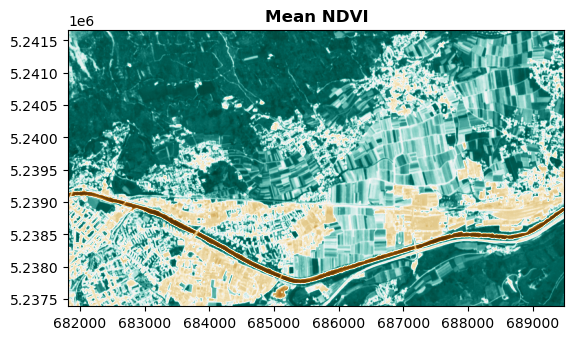

<AxesSubplot: title={'center': 'Mean NDVI'}>

In [19]:
import rasterio
from rasterio.plot import show

raster_template = rasterio.open(data_dir / "NDVI_mean.tif")
print(raster_template.profile)
rasterio.plot.show(raster_template, title="Mean NDVI", cmap="BrBG")

Now we can rasterize the reference data with Geopandas and Rasterio (as shown [here](https://pygis.io/docs/e_raster_rasterize.html)).

Alternatively, [GeoUtils]( https://geoutils.readthedocs.io/en/latest/index.html) might be an option for such operations but (as of 2023/01/25) it is still poorly documented.

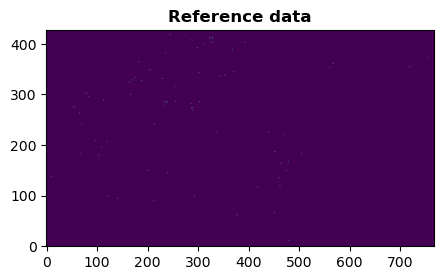

In [20]:
from rasterio import features

# Get list of geometries for all features in vector file (ref_data is a GeoDataFrame)
geom = [shapes for shapes in ref_data.geometry]

# Create tuples of geometry, value pairs, where value is the attribute value you want to burn
geom_value = ((geom,value) for geom, value in zip(ref_data.geometry, ref_data['landcover']))

# Rasterize vector using the shape and coordinate system of the template raster
ref_raster = features.rasterize(geom_value,
                                out_shape = raster_template.shape,
                                fill = raster_template.nodata,
                                out = None,
                                transform = raster_template.transform,
                                all_touched = True)

# Plot raster
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize = (5, 5))
show(ref_raster, title="Reference data", ax = ax)
plt.gca().invert_yaxis()        # Get xurrent Axes and invert y

The reference samples are only one pixel each and very hard to see. Write the rasterized reference data to disc and load to a GIS to check if everything went fine (... looks perfect;)). Each reference point is one labelled pixel now.

In [21]:
with rasterio.open(
        data_dir / "rasterized_ref_data.tif", "w",
        driver = "GTiff",
        transform = raster_template.transform,
        crs = raster_template.crs,
        dtype = rasterio.uint8,
        count = 1,
        width = raster_template.width,
        height = raster_template.height) as dst:
    dst.write(ref_raster, indexes = 1)

Read the GeoTiff with rasterized reference data to an xarray DataArray.

In [22]:
ref_data_da = rioxarray.open_rasterio(data_dir / "rasterized_ref_data.tif")

Add the labels from this reference data to our Dataset as a new variable.

In [23]:
S2_seasonal_ds['labels'] = ref_data_da


Clean up the Dataset: Remove dimensions *time* and *band* which have length 1 using ``squeeze()``, and drop coordinates *band* and *spatial_ref* using ``reset_coords()``.

In [24]:
S2_seasonal_ds = S2_seasonal_ds.squeeze().reset_coords(['time', 'band', 'spatial_ref'], drop=True)
S2_seasonal_ds

<xarray.Dataset>
Dimensions:      (y: 428, x: 767)
Coordinates:
  * y            (y) float64 5.242e+06 5.242e+06 ... 5.237e+06 5.237e+06
  * x            (x) float64 6.818e+05 6.818e+05 ... 6.895e+05 6.895e+05
Data variables:
    NDVI_max     (y, x) float64 0.6992 0.7314 0.7144 ... 0.8714 0.8441 0.9075
    NDVI_mean    (y, x) float64 0.5153 0.5224 0.5348 ... 0.7425 0.7466 0.7546
    NDVI_min     (y, x) float64 0.1644 0.1643 0.1623 ... 0.2503 0.2692 0.3074
    NDVI_stdDev  (y, x) float64 0.147 0.1533 0.1561 ... 0.1192 0.1084 0.1111
    labels       (y, x) uint8 ...
Attributes:
    transform:               (10.0, 0.0, 681820.0, 0.0, -10.0, 5241670.0)
    crs:                     +init=epsg:25832
    res:                     (10.0, 10.0)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

Maintain only the samples, i.e. pixels where a valid label (> 0) exists, mask out all other pixels (i.e. set them to nan).

In [25]:
samples_ds = S2_seasonal_ds.where(S2_seasonal_ds.labels > 0)

### Flatten array (stack dimensions)

Our samples data set is a raster with shape (n_features, n_cells_y, n_cells_x). Scikit-learn, however, expects it to be of shape (n_samples, n_features). In other words, the Scikit-learn algorithm doesn't care how the samples (pixels, each with feature values and a label) are ordered in 2D space. Therefore, we have to re-shape our data, i.e. flatten the x and y dimensions. We use xarray methods (`stack`) for this operation. This makes it possible to keep track of the coordinate labels ('x' and 'y') along the next steps and re-shape back to our array (in 2D raster space) later without loosing information.

Convert Dataset to DataArray and stack x and y dimensions, call new dimension "samples". This is a multi-index object, which can be unstacked into x and y later.

In [26]:
samples_da = samples_ds.to_array()
samples_da_flat = samples_da.stack(samples=('x', 'y'))
print("Shape and dimensions of samples_da: ", samples_da.shape, samples_da.dims)
print("Shape and dimensions of samples_da_flat: ", samples_da_flat.shape, samples_da_flat.dims)

Shape and dimensions of samples_da:  (5, 428, 767) ('variable', 'y', 'x')
Shape and dimensions of samples_da_flat:  (5, 328276) ('variable', 'samples')


To get our flattened array into the shape of n_samples, n_features (as expected by scikit-learn), we reorder the dimensions using .transpose.

In [27]:
samples_da_flat_t = samples_da_flat.transpose()
samples_da_flat_t.shape

(328276, 5)

Most scikit-learn estimators (including Random Forest) do not accept missing values, so we have to remove all NaNs in our samples.

In [28]:
samples_da_flat_t = samples_da_flat_t.dropna(dim='samples', how='any')
samples_da_flat_t.shape

(72, 5)

Define the predictors (features; *X*) and the predicted variable (dependent variable; *y*) in our samples.

In [29]:
X = samples_da_flat_t.sel(variable = ['NDVI_max', 'NDVI_min', 'NDVI_mean', 'NDVI_stdDev'])
y = samples_da_flat_t.sel(variable = ['labels'])

### Random Forest classification using scikit-learn

We use scikit-learn to fit a Random Forest (RF) classifier to the samples and apply this classifier to the entire AOI covered by our spectral temporal feature rasters.

In [32]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(oob_score=True)        # We use default values for the number of trees and other user-defined parameters
clf = clf.fit(X, y.squeeze(dim='variable'))         # Without squeeze we get a data converison warning (change the shape of y to (n_samples,); but it works!?)
print("Out-of-bag score: ", clf.oob_score_)

Out-of-bag score:  0.9583333333333334


Let's have a look at the feature importances provided by the Random Forest algorithm.

In [33]:
for i, j in zip(['NDVI_max', 'NDVI_min', 'NDVI_mean', 'NDVI_stdDev'], clf.feature_importances_):
    print(i, j)
    #plt.bar(i, j)

NDVI_max 0.2485345139795969
NDVI_min 0.21797916449933796
NDVI_mean 0.2271914501708344
NDVI_stdDev 0.3062948713502308


Note that this is a very much simplified analysis and many aspects (including the accuracy analysis) could be expanded. Please see Module 1 Theme 6 of the E-TRAINEE course for more details on accuracy analysis. For now, we go on with classification ...

### Classify all pixels of our AOI

The steps above were done for the samples only (recall that we have masked all unsampled pixels using xarray's ``where()``). Now we prepare the full rasters with spectral-temporal features for landcover classification across the entire AOI. *Could probably be simplified by re-ordering the processing steps.*

In [34]:
predict_da = S2_seasonal_ds.to_array()
predict_da = predict_da.stack(samples=('x', 'y'))
predict_da = predict_da.transpose()
X_predict = predict_da.sel(variable = ['NDVI_max', 'NDVI_min', 'NDVI_mean', 'NDVI_stdDev']).dropna(dim='samples', how='any')

Predict all pixels based on their feature vector and the classifier fitted on the samples.

In [35]:
labels_predicted = clf.predict(X_predict)

Convert the labels from float to integer.

In [36]:
import numpy as np
labels_predicted = labels_predicted.astype(int)

### Un-flatten the classification output

To be able to un-flatten (unstack) the spatial dimensions x and y of our predicted labels we use the flattened *predict_da* DataArray as a template. The original DataArray has the shape *n_samples by n_features*, we need a template with shape *n_samples*, so take only one of the variables. then fill this template with the predicted labels.

In [37]:
template_da_1d = predict_da[:, 0]                           # take only one variable
output_da_1d = template_da_1d.copy(data=labels_predicted)   # fill template with predicted labels

Now unstack the output to recover the spatial dimensions. At some point we had swapped the dimensions by ``transpose()``, so we have to undo this here by calling ``transpose()`` again.

Note that the output has "inherited" the metadata of the input data (such as CRS, cell size, etc.; stored as attributes). Unfortunately, it has also "inherited" the name of the variable used as template. To be able to rename it to 'landcover_id' we convert the DataArray to a Dataset. 

In [38]:
output_da_2d = output_da_1d.unstack().transpose()
output_ds_2d = output_da_2d.expand_dims('variable').to_dataset(dim='variable')
output_ds_2d = output_ds_2d.rename({'NDVI_max': 'landcover_id'})

Finally, write the classification output to disk.

In [39]:
landcover_out = output_ds_2d['landcover_id']
landcover_out.rio.write_crs(output_ds_2d.crs, inplace=True)
landcover_out.rio.write_nodata(0)#output_ds_2d.nodatavals[0])
landcover_out.rio.to_raster(data_dir / "landcover_id_v2.tif")

### Plot the results in a static map

We use the plotting capabilities of Pandas and xarray with matplotlib as plotting backend to create a static map with the reference data and the classification output (predicted labels for each pixel).

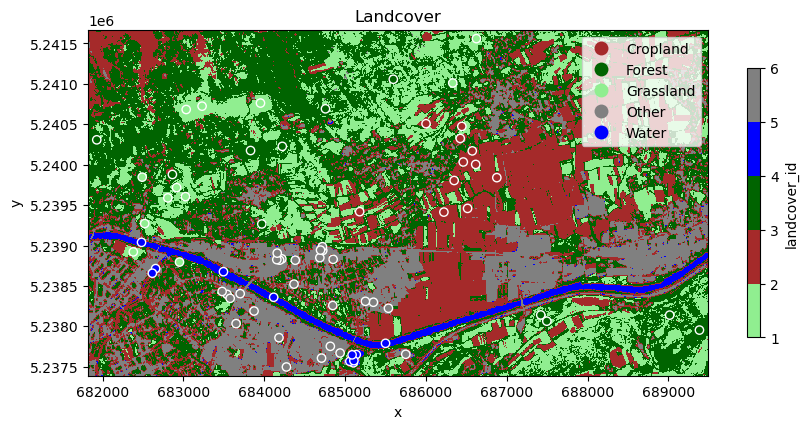

In [41]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

my_colors_by_ids = ("lightgreen", "brown", "darkgreen", "blue", "grey") # Define colors for landcover IDs

fig, ax = plt.subplots(1, figsize=(10,5))
output_ds_2d['landcover_id'].plot.imshow(ax=ax, levels=[1, 2, 3, 4, 5, 6], colors=my_colors_by_ids, cbar_kwargs={'shrink': 0.7})
ref_data.plot(ax=ax, column="landcover_string",                          # Column to use for color
   cmap=ListedColormap(['brown', 'darkgreen', 'lightgreen', 'grey', 'blue']),
    edgecolor='white',
    legend=True)
plt.title('Landcover')
plt.show()

### Interactive map of the results

Now let's build an interactive Folium map where we can zoom in to inspect the classification results in more detail (also against a web-based background map). Raster overlays in Folium are apparently not as straightforward as mapping vector layers ... So it could also make sense to vectorize the landcover map!?

Issues:
- Handle NoData values (currently they are zero and colored white; a workaround is shown [here](https://github.com/royalosyin/Overlay-GeoTiff-Raster-with-nodata-On-Interactive-Map/blob/master/scripts/ex2-Overlay%20Raster%20with%20nodata%20on%20Interactive%20Map%20with%20Folium.ipynb))
- Add colormap, e.g. https://jingwen-z.github.io/how-to-draw-a-map-with-folium-module-in-python/
- Add legend, e.g. https://nbviewer.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd, https://stackoverflow.com/questions/65042654/how-to-add-categorical-legend-to-python-folium-map

Open the classified landcover map and reproject it to WGS84 coordinate system, which is needed to overlay Folium maps.

In [42]:
with rioxarray.open_rasterio (data_dir / "landcover_id_v2.tif", 'rb', masked=True) as landcover_id_raster:
    landcover_wgs84 = landcover_id_raster.rio.reproject('EPSG:4326')

To make the raster data compatible with folium convert data type of raster values, convert xarray DataArray to numpy array, modify its shape.

In [43]:
landcover_wgs84 = landcover_wgs84.astype('uint8')
landcover_wgs84_np = landcover_wgs84.to_numpy()               # xarray DataArray to numpy array
landcover_wgs84_np = np.moveaxis(landcover_wgs84_np, 0, -1)   # bands must be on the third axis (y, x, bands)
landcover_wgs84_np.shape

(332, 842, 1)

In [45]:
# Show AOI
m = my_aoi.explore(                                     # Show the AOI in a Folium map object
    name="AOI",
    style_kwds={"fill": False}                          # Do not fill the polygon
)

# Add landcover point layer
ref_data.explore(
    m=m,                                                # Pass the map object
    column="landcover_string",                          # Column to use for color
    name="Landcover samples",                           # Layer name in the map
    marker_kwds={"radius": 4},                          # Set marker circle size in pixels
    style_kwds={"color": "black", "weight": 1},         # Set marker stroke color and width in pixels
    cmap=my_colors,                                     # Use the custom colormap
    legend=True 
)

# Create a bounding box from the landcover raster that can be passed to folium.
map_bounds_list = list(landcover_wgs84.rio.bounds())
map_bounds_nested_list = [[map_bounds_list[1], map_bounds_list[0]], [map_bounds_list[3], map_bounds_list[2]]]

# Overlay raster with landcover classification
m.add_child(folium.raster_layers.ImageOverlay(landcover_wgs84_np,
                                              name="Landcover predicted",
                                              opacity=.7,
                                              colormap=ListedColormap(['white', 'lightgreen', 'brown', 'darkgreen', 'blue', 'grey']),
                                              bounds=map_bounds_nested_list))
# Adding a categorical legend for this layer is complicated
# Fortunately, we have the legend of the point layer

# Add alternative background layers
folium.TileLayer('CartoDB positron', control=True).add_to(m)
folium.TileLayer(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                 attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
                 name='ESRI WorldImagery', control=True).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)          # Add layer control
m                                                       # Show map

### Unsupervised classification by kmeans clustering

After the supervised landcover classification with the Random Forest classifier, we try also an unsupervised classification with the KMeans algorithm. Let's see how well this classic and relatively simple method can divide the spectral-temporal feature vectors into meaningful clusters. We simply set the number of clusters to seven and hope that they will (at least to some degree) correspond to our target classes defined above if we merge some of the clusters.

In [58]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=0, n_init='auto').fit(X)     # fit the kmeans model on the samples only
clusters_predicted = kmeans.predict(X_predict)                          # apply the model to predict labels for all pixels
clusters_predicted.shape                                                # the predicted labels are a 1D Numpy array

C:\Users\Andi\Anaconda3\envs\gee_env_v03\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



(328276,)

### Un-flatten the clustering output

The following procedure is the same as before with the supervised classification output.

To be able to un-flatten (unstack) the spatial dimensions x and y of our predicted clusters we use the flattened *predict_da* DataArray as a template. The original DataArray has the shape *n_samples by n_features*, we need a template with shape *n_samples*, so take only one of the variables. Then fill this template with the predicted clusters.

In [59]:
template_da_1d = predict_da[:, 0]                           # take only one variable
output_da_1d = template_da_1d.copy(data=clusters_predicted)   # fill template with predicted labels

Now unstack the output to recover the spatial dimensions. At some point we had swapped the dimensions by ``transpose()``, so we have to undo this here by calling ``transpose()`` again.
Note that the output also has "inherited" the metadata of the input data (such as CRS, cell size, etc.; stored as attributes).

In [60]:
output_da_2d = output_da_1d.unstack().transpose()
output_ds_2d = output_da_2d.expand_dims('variable').to_dataset(dim='variable')
output_ds_2d = output_ds_2d.rename({'NDVI_max': 'Clusters'})

Plot a map with the clusters.

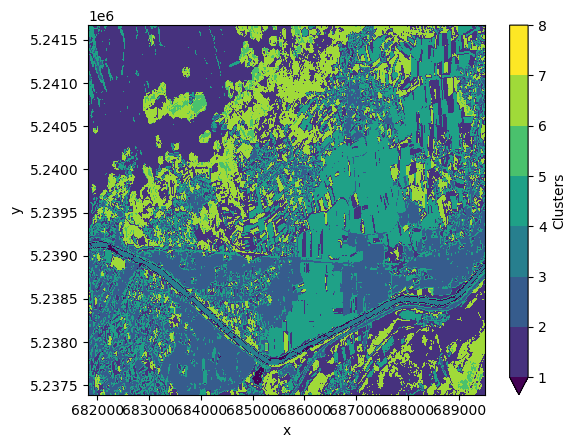

In [61]:
output_ds_2d['Clusters'].plot(levels=[1, 2, 3, 4, 5, 6, 7, 8])   # Define levels for a discrete colormap

Summarize some of the clusters and assign colors to all clusters, trying to match the result of the supervised classification/visual interpretation of the scene.

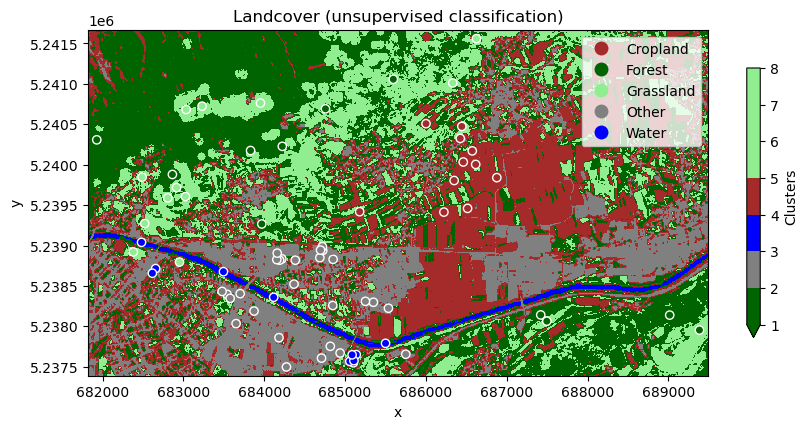

In [74]:
my_colors_by_clusters = ("darkgreen", "darkgreen", "grey", "blue", "brown", "lightgreen", "lightgreen", "lightgreen",) # Define colors for landcover IDs

fig, ax = plt.subplots(1, figsize=(10,5))
output_ds_2d['Clusters'].plot.imshow(ax=ax, levels=[1, 2, 3, 4, 5, 6, 7, 8], colors=my_colors_by_clusters, cbar_kwargs={'shrink': 0.7})
ref_data.plot(ax=ax, column="landcover_string",                          # Column to use for color
   cmap=ListedColormap(['brown', 'darkgreen', 'lightgreen', 'grey', 'blue']),
    edgecolor='white',
    legend=True)
plt.title('Landcover (unsupervised classification)')
plt.show()

That doesn't look completely bad, given that we used a relatively simple approach without any training data. It seems to be possible to assign class labels to the clusters. We don't do that now, but take the results of this unsupervised and the supervised classification as an indicator for the good predictive power of spectral-temporal metrics (such as minimum, maximum. mean and standard deviation of the NDVI) for landcover classification.

### Remaining problems and outlook

Have a look at the northwestern corner of our AOI. Strange location for cropland ...!? What is the correct label for this area? What happened here?

We will investigate this area in the hands-on part of theme 4.
